In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BeitModel, BeitFeatureExtractor
import numpy as np
import cv2
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import seaborn as sns
import pandas as pd

# Function to load and preprocess data (resize to 224x224)
def get_data(path):
    positive = path / "PNEUMONIA"
    negative = path / "NORMAL"
    im_positive_path = [*positive.glob("*.jpeg")]
    im_negative_path = [*negative.glob("*.jpeg")]
    im_path = im_positive_path + im_negative_path
    y = np.ones(len(im_path), dtype=int)
    y[len(im_positive_path):] = 0
    X = np.array([cv2.resize(cv2.imread(str(img), flags=cv2.IMREAD_GRAYSCALE), 
                             (224, 224)) for img in im_path])
    return X, y

# Data paths
root = pathlib.Path(r"D:\python\BEiT\archive\chest_xray")
train_path = root / "train"
test_path = root / "test"
val_path = root / "val"

X_train, y_train = get_data(train_path)
X_test, y_test = get_data(test_path)
X_val, y_val = get_data(val_path)

# Convert grayscale to RGB and resize images for BEiT input (224x224)
X_train_rgb = np.stack([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in X_train], axis=0)
X_test_rgb = np.stack([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in X_test], axis=0)
X_val_rgb = np.stack([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in X_val], axis=0)


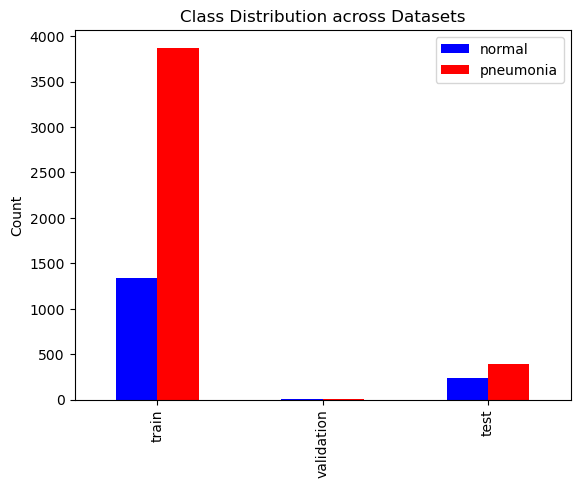

In [2]:
# Plot class distribution
class_names = ["Normal", "Pneumonia"]
class_counts = pd.Series(np.bincount(y_train)).rename("train").to_frame().merge(
    pd.Series(np.bincount(y_val)).rename("validation"), right_index=True, left_index=True).merge(
    pd.Series(np.bincount(y_test)).rename("test"), right_index=True, left_index=True).rename(
    index={0: "normal", 1: "pneumonia"}).T

ax = plt.subplot()
class_counts.plot(kind="bar", ax=ax, color=["blue", "red"])
plt.title("Class Distribution across Datasets")
plt.ylabel("Count")
plt.show()


In [3]:
# Load BEiT model and feature extractor
beit_model = BeitModel.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

# Apply BEiT feature extractor (resize to 224x224 and normalize)
X_train_resized = torch.tensor(np.concatenate([feature_extractor(images=x, return_tensors="pt")["pixel_values"] for x in X_train_rgb]))
X_test_resized = torch.tensor(np.concatenate([feature_extractor(images=x, return_tensors="pt")["pixel_values"] for x in X_test_rgb]))
X_val_resized = torch.tensor(np.concatenate([feature_extractor(images=x, return_tensors="pt")["pixel_values"] for x in X_val_rgb]))

y_train = torch.tensor(y_train).float().unsqueeze(1)
y_test = torch.tensor(y_test).float().unsqueeze(1)
y_val = torch.tensor(y_val).float().unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_resized, y_train)
val_dataset = TensorDataset(X_val_resized, y_val)
test_dataset = TensorDataset(X_test_resized, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


c:\Users\cubid\anaconda3\Lib\site-packages\transformers\models\beit\feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
c:\Users\cubid\anaconda3\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `BeitFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [11]:
# Define BEiT classifier model with Masked Image Modeling for pre-training
class BEiTWithMIM(nn.Module):
    def __init__(self):
        super(BEiTWithMIM, self).__init__()
        self.beit_model = BeitModel.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(768, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.beit_model(x).last_hidden_state[:, 0, :]  # CLS token
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return torch.sigmoid(self.fc3(x))
    
    def masked_forward(self, x, mask_ratio=0.15):
        # Get the embeddings from BEiT without forward pass through the head
        outputs = self.beit_model(x, output_hidden_states=True)
        embeddings = outputs.last_hidden_state  # Shape: (batch_size, num_patches, hidden_size)

        # Apply masking to the embeddings
        batch_size, num_patches, hidden_size = embeddings.shape
        mask = torch.rand(batch_size, num_patches).to(x.device) < mask_ratio  # Create mask with shape (batch_size, num_patches)
        
        # Apply mask: set masked patches to zero
        masked_embeddings = embeddings.clone()
        masked_embeddings[mask] = 0  # Zero out masked patches
        
        # Return both masked and original embeddings (for loss calculation)
        return masked_embeddings, embeddings, mask

# Initialize model and optimizer
model = BEiTWithMIM()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  # Use MSELoss for reconstruction task
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Stage 1: Masked Image Modeling (Pre-training with MIM)
num_epochs_mim = 30
mask_ratio = 0.40  # Mask 40% of the image patches

for epoch in range(num_epochs_mim):
    model.train()
    running_loss = 0.0
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        
        # Perform masked forward
        masked_embeddings, original_embeddings, mask = model.masked_forward(X_batch, mask_ratio=mask_ratio)
        
        # Calculate loss only on masked patches
        loss = loss_fn(masked_embeddings[mask], original_embeddings[mask])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'MIM Pre-training, Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')


MIM Pre-training, Epoch 1, Loss: 5.320937881440472
MIM Pre-training, Epoch 2, Loss: 0.4694593136478787
MIM Pre-training, Epoch 3, Loss: 0.6543294362312445
MIM Pre-training, Epoch 4, Loss: 0.21349531073877417
MIM Pre-training, Epoch 5, Loss: 0.17370524275705126
MIM Pre-training, Epoch 6, Loss: 0.17399483032387458
MIM Pre-training, Epoch 7, Loss: 0.10809306190149184
MIM Pre-training, Epoch 8, Loss: 0.17843686496736083
MIM Pre-training, Epoch 9, Loss: 0.12510240354512367
MIM Pre-training, Epoch 10, Loss: 0.0943251388387446
MIM Pre-training, Epoch 11, Loss: 0.09002440212511577
MIM Pre-training, Epoch 12, Loss: 0.6536943478498356
MIM Pre-training, Epoch 13, Loss: 0.31588087048084457
MIM Pre-training, Epoch 14, Loss: 0.1290536427790402
MIM Pre-training, Epoch 15, Loss: 0.09680036811923688
MIM Pre-training, Epoch 16, Loss: 0.11283247362525185
MIM Pre-training, Epoch 17, Loss: 0.8990582129203835
MIM Pre-training, Epoch 18, Loss: 0.4986306541810738
MIM Pre-training, Epoch 19, Loss: 0.1450289921

In [12]:
# Stage 2: Fine-tuning for pneumonia detection

# Freeze layers for fine-tuning
def freeze_beit_layers(model, freeze_until_layer: int):
    # Freeze until a certain layer
    for name, param in model.beit_model.named_parameters():
        layer_num = int(name.split('.')[2]) if 'encoder' in name else -1  # Extract layer number
        if layer_num < freeze_until_layer:
            param.requires_grad = False
        else:
            param.requires_grad = True

# Initialize model and optimizer for fine-tuning
model = BEiTWithMIM()
freeze_until_layer = 3  # Freeze first 6 layers of BEiT
freeze_beit_layers(model, freeze_until_layer)

# Move model to device
model.to(device)

# Optimizer only for parameters that require grad
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
loss_fn1 = nn.BCEWithLogitsLoss()
# Fine-tuning with frozen layers
num_epochs_finetune = 40
for epoch in range(num_epochs_finetune):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn1(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Fine-tuning, Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')


Fine-tuning, Epoch 1, Loss: 0.5901571634722633
Fine-tuning, Epoch 2, Loss: 0.45203276115692465
Fine-tuning, Epoch 3, Loss: 0.4345522596060864
Fine-tuning, Epoch 4, Loss: 0.4285856039246167
Fine-tuning, Epoch 5, Loss: 0.43801330843586134
Fine-tuning, Epoch 6, Loss: 0.44842622342285204
Fine-tuning, Epoch 7, Loss: 0.42996529805148304
Fine-tuning, Epoch 8, Loss: 0.43201863235491184
Fine-tuning, Epoch 9, Loss: 0.42745202560366297
Fine-tuning, Epoch 10, Loss: 0.42491401430287973
Fine-tuning, Epoch 11, Loss: 0.42764886811467034
Fine-tuning, Epoch 12, Loss: 0.4256972301225721
Fine-tuning, Epoch 13, Loss: 0.4327074188761916
Fine-tuning, Epoch 14, Loss: 0.42468066998054643
Fine-tuning, Epoch 15, Loss: 0.4276654603291143
Fine-tuning, Epoch 16, Loss: 0.4291375491516722
Fine-tuning, Epoch 17, Loss: 0.4330007541764733
Fine-tuning, Epoch 18, Loss: 0.4401386936018072
Fine-tuning, Epoch 19, Loss: 0.42395844379085706
Fine-tuning, Epoch 20, Loss: 0.42843012996246477
Fine-tuning, Epoch 21, Loss: 0.4232404

Validation Report
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         8
   Pneumonia       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

Test Report
              precision    recall  f1-score   support

      Normal       1.00      0.49      0.66       234
   Pneumonia       0.76      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.74      0.76       624
weighted avg       0.85      0.81      0.79       624



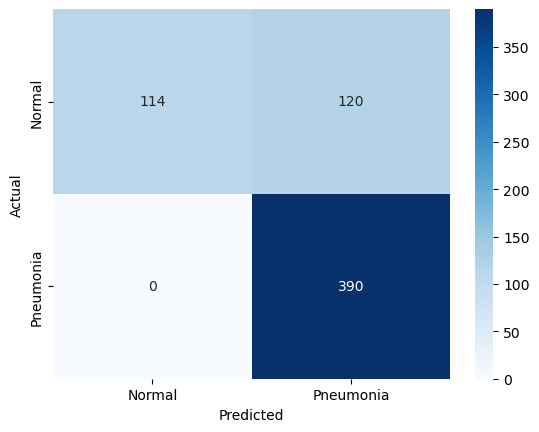

<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

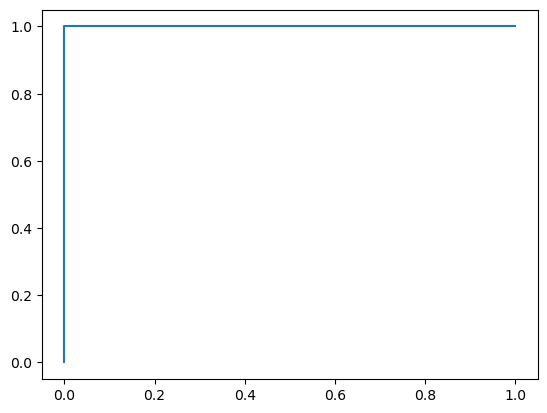

In [13]:
# Predict and evaluate
def predict(loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).cpu().numpy()
            all_preds.append(preds)
    return np.vstack(all_preds)

preds_val = predict(val_loader)
preds_test = predict(test_loader)

# Calculate metrics
y_val_pred = (preds_val >= 0.5).astype(int)
y_test_pred = (preds_test >= 0.5).astype(int)

print("Validation Report")
print(classification_report(y_val, y_val_pred, target_names=class_names))
print("Test Report")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion matrix and ROC curve
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr_val, tpr_val, _ = roc_curve(y_val, preds_val)
plt.plot(fpr_val, tpr_val, label="ROC Curve (Validation)")
plt.xlabel


C:\Users\cubid\AppData\Local\Temp\ipykernel_4676\3241126606.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(feature_extractor(images=image_rgb, return_tensors="pt")["pixel_values"]).to(device)  # Send to CUDA


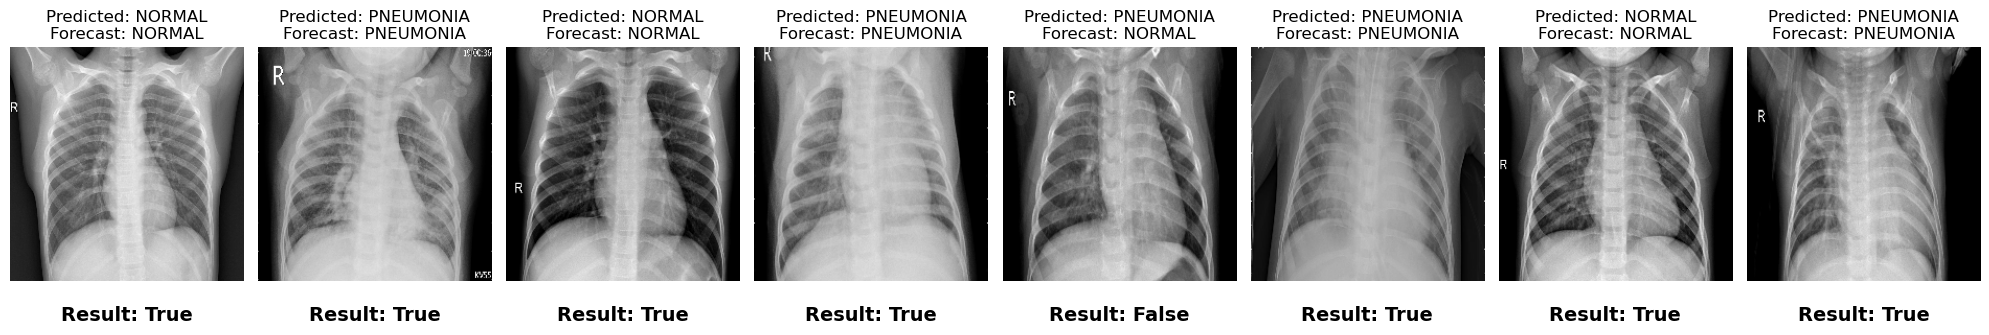

In [18]:
import os

# Function to preprocess, predict, and show image with results using CUDA
def predict_and_show_images(image_paths):
    # Set up the plot for multiple images with increased space
    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 6))  # Increased figsize for better spacing
    
    results = []
    for i, image_path in enumerate(image_paths):
        # Load and preprocess each image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_resized = cv2.resize(image, (224, 224))
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
        
        # Convert to tensor and apply BEiT feature extractor
        image_tensor = torch.tensor(feature_extractor(images=image_rgb, return_tensors="pt")["pixel_values"]).to(device)  # Send to CUDA
        
        # Forward pass through the model using CUDA
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)  # Model and tensor are on CUDA
            prediction = torch.sigmoid(output).cpu().item()  # Transfer back to CPU for output
        
        # Convert prediction to class label
        predicted_label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
        
        # Get the true label from the folder name
        true_label = os.path.basename(os.path.dirname(image_path))
        
        # Check if prediction matches the true label
        result = predicted_label == true_label
        results.append((image_path, true_label, predicted_label, prediction, result))
        
        # Show the image
        axes[i].imshow(cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB))
        axes[i].set_title(f"Predicted: {predicted_label}\nForecast: {true_label}", fontsize=12)
        
        # Show result (True/False) below the image with larger font size
        axes[i].text(0.5, -0.15, f"Result: {result}", ha='center', va='center', fontsize=14, transform=axes[i].transAxes, fontweight='bold')
        axes[i].axis('off')  # Turn off axes for a cleaner look
    
    # Adjust spacing between images
    plt.subplots_adjust(wspace=0.4)  # Increase horizontal spacing between subplots
    plt.tight_layout()
    plt.show()

# List of 4 test images (replace with your actual image paths)
test_image_paths = [
    r"D:\python\BEiT\archive\chest_xray\chest_xray\test\NORMAL\IM-0089-0001.jpeg",
    r"D:\python\BEiT\archive\chest_xray\chest_xray\test\PNEUMONIA\person49_virus_101.jpeg",
    r"D:\python\BEiT\archive\chest_xray\test\NORMAL\IM-0086-0001.jpeg",
    r"D:\python\BEiT\archive\chest_xray\chest_xray\test\PNEUMONIA\person59_virus_116.jpeg",
    r"D:\python\BEiT\archive\chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0315-0001.jpeg",
    r"D:\python\BEiT\archive\chest_xray\chest_xray\test\PNEUMONIA\person119_bacteria_565.jpeg",
    r"D:\python\BEiT\archive\chest_xray\chest_xray\test\NORMAL\NORMAL2-IM-0323-0001.jpeg",
    r"D:\python\BEiT\archive\chest_xray\chest_xray\test\PNEUMONIA\person158_bacteria_745.jpeg"
]

# Predict and display images with labels
predict_and_show_images(test_image_paths)

